In [1]:
import scipy
import fitsio
import smatch
import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import hpgeom
import numba
import tqdm

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
_ed = fitsio.read("des_exposure_data.fits")

In [3]:
_ed = np.sort(_ed, order="mjd_obs")

In [4]:
_ed.shape

(100802,)

In [5]:
from silly_cal.models import nights_with_mirror

nside = 1024
nside = 256

fd = nights_with_mirror.gen_fake_data(
    edata=_ed[_ed["band"] == "r"],
    # edata=_ed[(_ed["mjd_obs"] < 57200) & (_ed["band"] == "r")],
    # edata=_ed[(_ed["mjd_obs"] > 57900) & (_ed["band"] == "r")],
    # edata=_ed[(_ed["mjd_obs"] > 57500) & (_ed["mjd_obs"] < 57900) & (_ed["band"] == "r")],
    nside=nside,
    seed=10,
    target_nstar=20e6,
)

<a list of 1 Line2D objects>

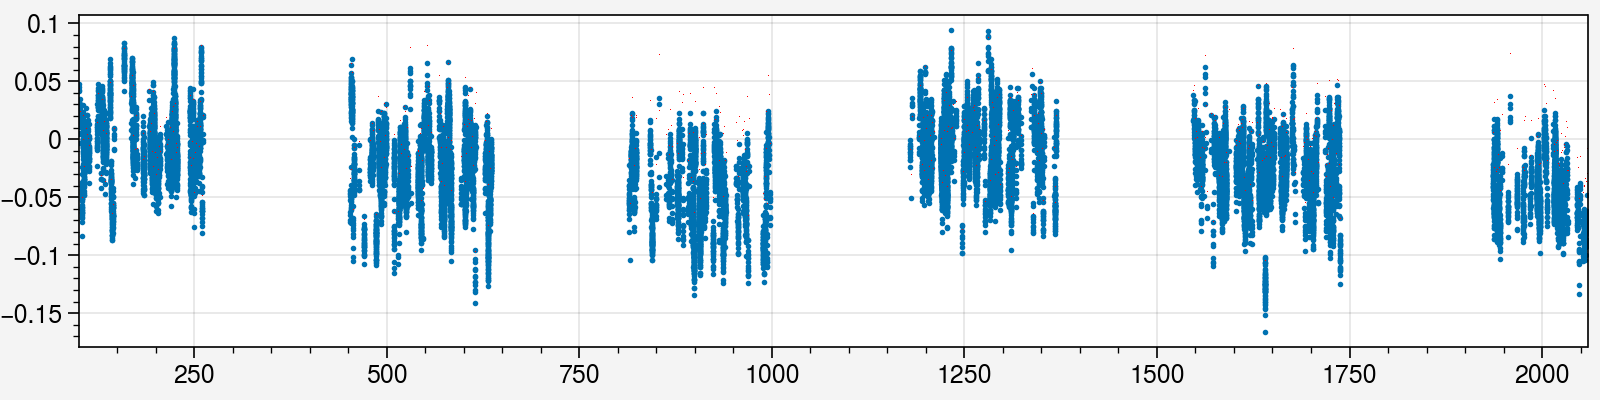

In [6]:
fig, axs = pplt.subplots(figsize=(8, 2))

axs.plot(fd["data"]["night"], fd["data"]["true_zp"], ".", markersize=2)
yv = fd["data"]["true_zp_night"][fd["data"]["inv_unight"]]
axs.plot(fd["data"]["night"], yv, ",", color="r")

# axs.format(ylim=(-1.5, 0.2), xlim=(0, 50))

## Use Adaptive Gradient Descent

In [7]:
from silly_cal.optimizers import run_amsgrad, run_laprop

In [8]:
from functools import partial

pars = nights_with_mirror.gen_guess(fd["opt_kwargs"])
grad = np.zeros_like(pars)
nt = numba.get_num_threads()
tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

def ofun(pars):
    return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])

ores = run_laprop(ofun, pars, 1e-3, 1000)
ores

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
chi2/dof = 9.02390715e-01:  90%|███████████▋ | 901/1000 [00:38<00:04, 23.61it/s]


{'opt': {'mt': array([0.04331991, 0.04189387, 0.0075161 , ..., 0.00800944, 0.01215314,
         0.00819287]),
  'nt': array([1.44443463e-02, 1.26532292e-02, 2.79680969e-06, ...,
         2.09144767e-11, 3.03004560e-10, 2.14660181e-11]),
  't': 901,
  'fval_prev': 0.9023907146196068},
 'flags': 0,
 'x': array([-0.06001372, -0.05387697,  0.03537546, ...,  0.00626774,
         0.00748089,  0.00345052]),
 'fun': 0.9023909346869927}

In [9]:
fdd = fd["data"]

In [10]:
fdd["true_tel_eff"], ores["x"][0:fdd["true_tel_eff"].shape[0]]

(array([-0.05227977, -0.05202662]), array([-0.06001372, -0.05387697]))

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import healsparse as hsp

import skyproj

In [12]:
hmap = hsp.HealSparseMap.make_empty(32, nside, np.float64)

In [13]:
est_star = ores["x"][fd["opt_kwargs"]["nyear"] + fd["opt_kwargs"]["nnight"]+fd["opt_kwargs"]["nexp"]:]

dstar = est_star - fdd["true_star"]

hmap.update_values_pix(fdd["true_star_nest_ind"], dstar)

In [14]:
from mattspy.stats import mad

np.mean(dstar), mad(dstar)

(0.0027846018017931456, 0.0026006466410449245)

(<matplotlib.colorbar.Colorbar at 0x146692d70>,
 <AxesHostAxes:xlabel='std [mmag]'>)

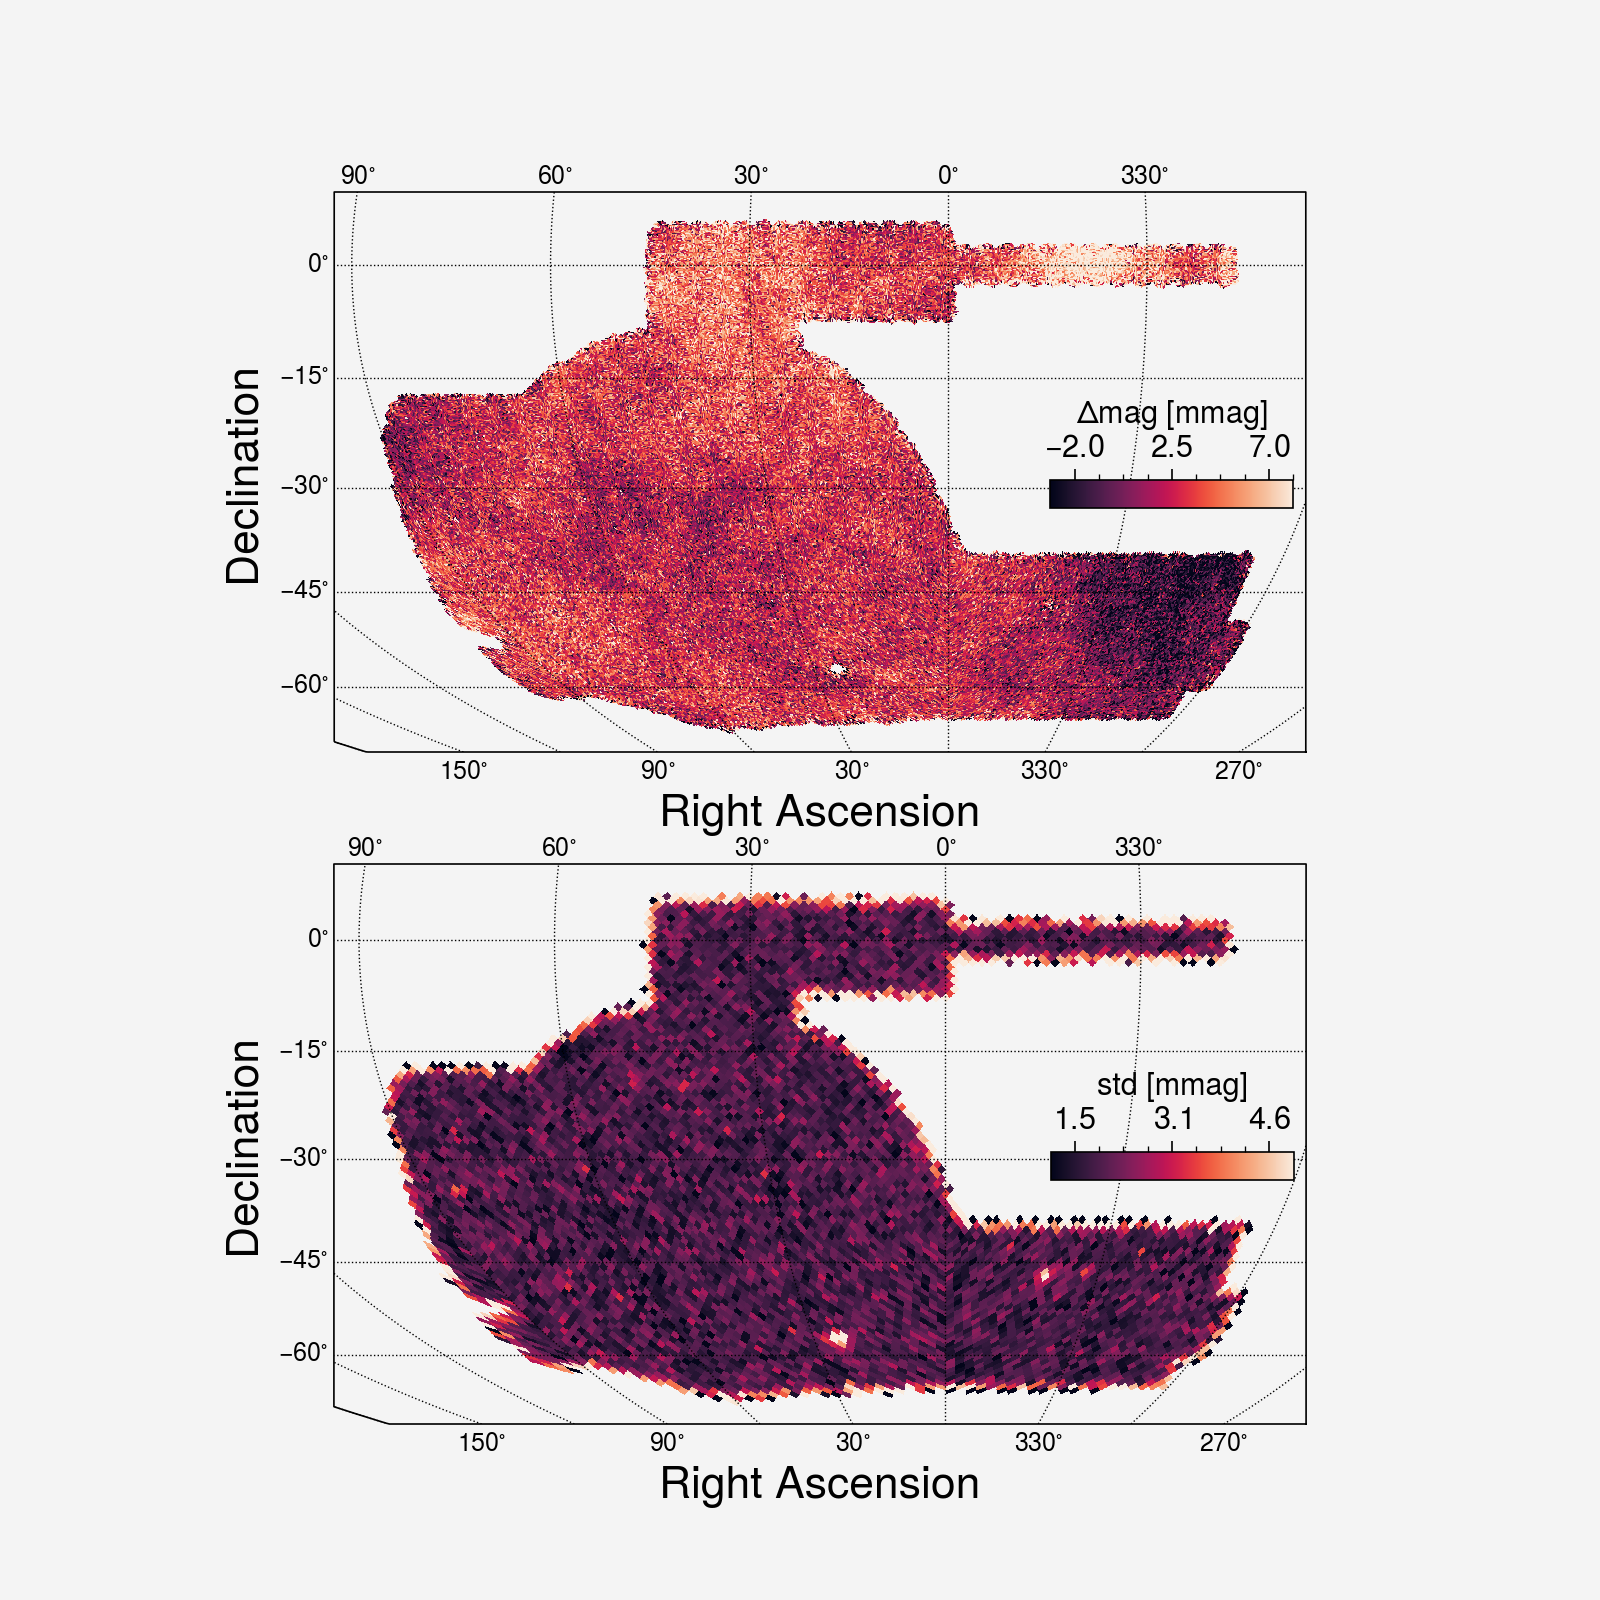

In [15]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8, 8), squeeze=False)

mn_map = hmap.degrade(64, reduction="mean")
sd_map = hmap.degrade(64, reduction="std")
mean_sd = np.median(sd_map.get_values_pix(sd_map.valid_pixels))

sp = skyproj.McBrydeSkyproj(ax=axs[0, 0])
sp.draw_hspmap(hmap * 1e3, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag$ [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
sp.draw_hspmap(sd_map / 1e-3, cmap="rocket")
sp.draw_inset_colorbar(label="std [mmag]")